# 4X Study Dashboard
This notebook is used to analyze data from the 4X study conducted in March 2018.

# Imports and Global Setup

In [1]:
import json
from multiprocessing import Pool, cpu_count
from multiprocessing.dummy import Pool as ThreadPool 
from functools import reduce
from collections import Counter

import requests
import pandas as pd
import numpy as np

from datetime import datetime, timezone
from copy import deepcopy
from tqdm import *

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

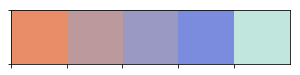

In [3]:
# defining colors
COLORS = {
    'ORANGE': '#E88D67',
    'PINK': '#BB999C',
    'VIOLET': '#9999C3',
    'BLUE': '#7B8CDE',
    'GREEN': '#C0E6DE'
}

# palette
sns.set_palette(COLORS.values())
sns.palplot(sns.color_palette())
sns.set(font_scale=1.5, style='whitegrid')

# Load in data

In [4]:
# URLs for different conditions
url_4x = 'https://les-4x.herokuapp.com/parse/classes/'
url_opp_location = 'https://les-opplocation.herokuapp.com/parse/classes/'
url_opp_distance = 'https://les-oppdistance.herokuapp.com/parse/classes/'

# shared header and data
header = {'X-Parse-Application-Id': 'PkngqKtJygU9WiQ1GXM9eC0a17tKmioKKmpWftYr'}
data = {'limit': '10000'}

# study start and end
start_time = '2018-03-05 06:00:00'
end_time = '2018-03-19 05:00:00'
print('Study Length: {}'.format(datetime.strptime(end_time, '%Y-%m-%d %H:%M:%S') - datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S')))

Study Length: 13 days, 23:00:00


In [5]:
def load_data(base_url, header, data, start_time, end_time):
    """
    Loads in all needed tables from database, given url.
    
    Input: 
        base_url (string): url to pull data from
        header (dict): application id and other auth
        data (dict): data to pass into query
        start_time (datetime): start time for data
        end_time (datetime): end time for data 
    
    Return:
        (dict): dict where keys are collection names and values are Pandas objects containing data
    """
    # declare collection list
    collection_list = ['_User', 'ServerLog', 'DebugLog', 'ForYouViewLog', 'ApplicationHeartbeat',
                       'TaskLocations', 'LocationTypeMetadata', 'beacons', 'EnRouteLocations',
                       'AtLocationNotificationsSent', 'AtLocationNotificationResponses',
                       'EnRouteNotificationsSent', 'EnRouteNotificationResponses',
                       'AtDistanceNotificationsSent', 'AtDistanceNotificationResponses']
    
    # loop through and load data for each collection
    output = {}
#     for collection in tqdm(collection_list):
    for collection in collection_list:
        current_response = requests.get(base_url + collection, headers=header, data=data)

        current_data = pd.DataFrame(current_response.json()['results'])
        if len(current_data) != 0 and collection not in ['LocationTypeMetadata', 'EnRouteLocations']:
            current_data['createdAt'] = pd.to_datetime(current_data['createdAt'])
            current_data['updatedAt'] = pd.to_datetime(current_data['updatedAt'])
            
            if collection != '_User':
                current_data = current_data[(current_data['createdAt'] >= start_time) & (current_data['createdAt'] < end_time)]

        output[collection] = current_data
    
    return output

def load_data_parallel(url):
    return load_data(url, header, data, start_time, end_time)

In [6]:
urls = [url_4x, url_opp_location, url_opp_distance]
pool = ThreadPool(cpu_count())
results = pool.map(load_data_parallel, urls)

In [7]:
data_4x = results[0]
data_opp_loc = results[1]
data_opp_dist = results[2]

# Data Setup
This section of the notebook is used to monitor the data coming in from the study. Some measures we see here may be used within the paper

## Common Functions and Data

In [10]:
def get_merged_at_location(tasklocations, atlocnotif, atlocresp):
    """
    Sets up a Pandas DataFrame with (1) TaskLocation, (2) NotificationSent, and (3) NotificationResponse data
    merged together for AtLocation case.
    
    Input:
        tasklocations (DataFrame): DataFrame of TaskLocations
        atlocnotif (DataFrame): DataFrame of AtLocationNotificationsSent
        atlocresp (DataFrame): DataFrame of AtLocationNotificationResponses
    
    Return:
        (DataFrame): merged DataFrame of inputs
    """
    # get AtLocationNotifications without duplicates
    atlocnotif.drop_duplicates(subset=['taskLocationId', 'vendorId'], keep='last', inplace=True)
    atlocnotif.drop(['objectId', 'createdAt', 'updatedAt'], axis=1, inplace=True)

    # get AtLocationNotificationResponses without duplicates
    atlocresp.drop_duplicates(subset=['taskLocationId', 'vendorId'], keep='last', inplace=True)
    atlocresp.drop(['objectId', 'createdAt', 'updatedAt'], axis=1, inplace=True)
    
    # combine AtLocation notifications and responses, with some data from TaskLocations
    atloc = atlocnotif.merge(tasklocations[['objectId', 'locationType', 'locationName', 'beaconId']],
                             how='inner', left_on='taskLocationId', right_on='objectId')
    atloc = atloc.merge(atlocresp[['question', 'response', 'timestamp', 'taskLocationId', 'vendorId']],
                        how='left', on=['taskLocationId', 'vendorId'])
    
    # clean columns
    del atloc['objectId']
    atloc.rename(columns={'timestamp_x': 'notificationTimestamp', 'timestamp_y': 'responseTimestamp'},
                 inplace=True)
    
    # fill blank columns
    atloc[['question', 'response']] = atloc[['question', 'response']].fillna(value='Missed Notification')
    atloc[['distanceToLocation', 'responseTimestamp']] = atloc[['distanceToLocation', 'responseTimestamp']].fillna(value=-1)

    # type columns
    atloc_int_cols = ['gmtOffset','notificationTimestamp', 'responseTimestamp']
    atloc[atloc_int_cols] = atloc[atloc_int_cols].apply(lambda x: x.astype(np.int64))
    
    # add remappedResponses column 
    invalid_responses = ['I don\'t know', 'com.apple.UNNotificationDismissActionIdentifier', 'Missed Notification']
    atloc['remappedResponses'] = atloc['response']
    atloc.loc[~atloc['remappedResponses'].isin(invalid_responses), 'remappedResponses'] = 'Valid Response'
    atloc.loc[atloc['remappedResponses'] == 'com.apple.UNNotificationDismissActionIdentifier', 'remappedResponses'] = 'Dismissed Notification'
    atloc.loc[atloc['remappedResponses'] == 'I don\'t know', 'remappedResponses'] = '"I don\'t know" Response'
    
    # reorder columns
    atloc_col_ordering = ['taskLocationId', 'vendorId', 'beaconId', 'distanceToLocation',
                          'locationType', 'locationName','gmtOffset', 'notificationTimestamp', 'notificationString',
                          'question', 'response', 'remappedResponses', 'responseTimestamp']
    atloc = atloc[atloc_col_ordering]
    
    return atloc

In [11]:
def get_merged_at_distance(tasklocations, atdistnotif, atdistresp):
    """
    Sets up a Pandas DataFrame with (1) TaskLocation, (2) NotificationSent, and (3) NotificationResponse data
    merged together for AtDistance case.
    
    Input:
        tasklocations (DataFrame): DataFrame of TaskLocations
        atdistnotif (DataFrame): DataFrame of AtDistanceNotificationsSent
        atdistresp (DataFrame): DataFrame of AtDistanceNotificationResponses
    
    Return:
        (DataFrame): merged DataFrame of inputs
    """
    # get AtDistanceNotifications without duplicates
    atdistnotif.drop_duplicates(subset=['taskLocationId', 'vendorId'], keep='last', inplace=True)
    atdistnotif.drop(['objectId', 'createdAt', 'updatedAt'], axis=1, inplace=True)

    # get AtDistanceNotificationResponses without duplicates
    atdistresp.drop_duplicates(subset=['taskLocationId', 'vendorId'], keep='last', inplace=True)
    atdistresp.drop(['objectId', 'createdAt', 'updatedAt'], axis=1, inplace=True)
    
    # combine AtDistance notifications and responses, with some data from TaskLocations
    atdist = atdistnotif.merge(tasklocations[['objectId', 'beaconId', 'locationName']],
                               how='inner', left_on='taskLocationId', right_on='objectId')
    atdist = atdist.merge(atdistresp[['emaResponse', 'timestamp', 'taskLocationId', 'vendorId']],
                          how='left', on=['taskLocationId', 'vendorId'])
    
    # clean columns
    del atdist['objectId']
    atdist.rename(columns={'timestamp_x': 'notificationTimestamp', 'timestamp_y': 'responseTimestamp'}, inplace=True)

    atdist_col_ordering = ['taskLocationId', 'vendorId', 'beaconId', 'distanceToLocation', 'bearingToLocation',
                           'locationType', 'locationName', 'notificationDistance', 'sentBy', 'infoIncluded',
                           'gmtOffset', 'notificationTimestamp', 'emaResponse', 'responseTimestamp']
    atdist = atdist[atdist_col_ordering]
    
    # fill blank columns
    atdist['emaResponse'] = atdist['emaResponse'].fillna(value='Missed Notification')
    atdist['responseTimestamp'] = atdist['responseTimestamp'].fillna(value=-1)
    
    # remap columns
    atdist.loc[atdist['emaResponse'] == 'com.apple.UNNotificationDismissActionIdentifier', 'emaResponse'] = 'Dismissed Notification'

    # type columns
    atdist_int_cols = ['gmtOffset','notificationTimestamp', 'responseTimestamp']
    atdist[atdist_int_cols] = atdist[atdist_int_cols].apply(lambda x: x.astype(np.int64))
    
    return atdist

In [12]:
def get_merged_en_route(enroutelocations, enroutenotif, enrouteresp):
    """
    Sets up a Pandas DataFrame with (1) EnRouteLocations, (2) NotificationSent, and (3) NotificationResponse data
    merged together for EnRoute case.
    
    Input:
        enroutelocations (DataFrame): DataFrame of EnRouteLocations
        enroutenotif (DataFrame): DataFrame of EnRouteNotificationsSent
        enrouteresp (DataFrame): DataFrame of EnRouteNotificationResponses
    
    Return:
        (DataFrame): merged DataFrame of inputs
    """
    # get EnRouteNotifications without duplicates
    enroutenotif.drop_duplicates(subset=['enRouteLocationId', 'vendorId'], keep='last', inplace=True)
    enroutenotif.drop(['objectId', 'createdAt', 'updatedAt'], axis=1, inplace=True)

    # get AtDistanceNotificationResponses without duplicates
    enrouteresp.drop_duplicates(subset=['enRouteLocationId', 'vendorId'], keep='last', inplace=True)
    enrouteresp.drop(['objectId', 'createdAt', 'updatedAt'], axis=1, inplace=True)
    
    # combine EnRouteNotifications and responses, with some data from EnRouteLocations
    enroute = enroutenotif.merge(enroutelocations[['objectId', 'locationName', 'locationType']],
                               how='inner', left_on='enRouteLocationId', right_on='objectId')
    enroute = enroute.merge(enrouteresp[['questionResponse', 'timestamp', 'enRouteLocationId', 'vendorId']],
                            how='left', on=['enRouteLocationId', 'vendorId'])
    
    # clean columns
    del enroute['objectId']
    enroute.rename(columns={'timestamp_x': 'notificationTimestamp', 'timestamp_y': 'responseTimestamp'}, inplace=True)

    enroute_col_ordering = ['enRouteLocationId', 'vendorId', 'distanceToLocation', 'locationType', 'locationName',
                           'gmtOffset', 'notificationTimestamp', 'questionResponse', 'responseTimestamp']
    enroute = enroute[enroute_col_ordering]
    
    # fill blank columns
    enroute['questionResponse'] = enroute['questionResponse'].fillna(value='Missed Notification')
    enroute.loc[enroute['questionResponse'] == 'com.apple.UNNotificationDismissActionIdentifier', 'questionResponse'] = 'Dismissed Notification'
    
    enroute['responseTimestamp'] = enroute['responseTimestamp'].fillna(value=-1)
    
     # add validResponse column 
    invalid_responses = ['I don\'t know', 'com.apple.UNNotificationDismissActionIdentifier', 'Missed Notification']
    enroute['remappedResponses'] = enroute['questionResponse']
    enroute.loc[~enroute['remappedResponses'].isin(invalid_responses), 'remappedResponses'] = 'Valid Response'
    enroute.loc[enroute['remappedResponses'] == 'I don\'t know', 'remappedResponses'] = '"I don\'t know" Response'

    # type columns
    enroute_int_cols = ['gmtOffset','notificationTimestamp', 'responseTimestamp']
    enroute[enroute_int_cols] = enroute[enroute_int_cols].apply(lambda x: x.astype(np.int64))
    
    return enroute

In [13]:
def get_dead_apps(serverlog):
    """
    Returns a list of lists for dead apps that server has notified.
    
    Input: 
        server (DataFrame): DataFrame of ServerLog
    
    Return:
        (list of lists of strings): all dead applications notified via push
    """
    notify_log_strings = serverlog[serverlog['logString'].str.contains('Notified dead')]['logString']
    deadapp_notif_list = list(notify_log_strings.apply(lambda x: x[x.find('[') + 1:-1].split(', ')))
    return deadapp_notif_list

In [14]:
location_scaffolds = {}
for index, row in data_4x['LocationTypeMetadata'].iterrows():
    location_scaffolds[row['locationType']] = row['scaffold']
location_scaffolds

{'coffeeshop': {'privateseating': '',
  'privateseatingoutlets': '',
  'privateseatingwindows': '',
  'sharedseating': '',
  'sharedseatingoutlets': '',
  'sharedseatingwindows': ''},
 'freefood': {'foodtype': '', 'stillleft': ''},
 'gym': {'ellipticals': '',
  'freeweights': '',
  'freeweightsbenches': '',
  'freeweightssquatracks': '',
  'stretch': '',
  'stretchmats': '',
  'stretchrollers': '',
  'treadmills': ''},
 'workspace': {'privateseating': '',
  'privateseatingoutlets': '',
  'sharedseating': '',
  'sharedseatingoutlets': '',
  'whiteboards': '',
  'whiteboardsmarkers': ''}}

## 4X Data Setup

In [15]:
users_4x = deepcopy(data_4x['_User'])
users_4x = users_4x[users_4x['vendorId'] != '']

In [16]:
serverlog_4x = deepcopy(data_4x['ServerLog'])
deadapp_notify_4x = get_dead_apps(serverlog_4x)
print('Last dead apps notified (count = {}): \n{}'.format(len(deadapp_notify_4x[-1]),
                                                          '\n'.join(deadapp_notify_4x[-1])))

flattened_deadapps_4x = reduce(lambda x, y: x + y, deadapp_notify_4x, [])
Counter(flattened_deadapps_4x)

Last dead apps notified (count = 15): 
B58B0DF7-8DA5-4A22-98EF-2AE712D4DB10
4B4115BA-BF8C-4F05-9B6E-7862FA08FC5F
F57CB6D4-09B3-4796-AE91-2F31BADEE832
95674A2B-6954-49C6-9456-A7F865CE686E
437A2325-CA4D-4426-9F1A-F89E412A00AC
E89FDDC1-0ADA-4249-B9AD-40F24FD9DE30
4D412B42-A080-49E7-A091-74C42D2778BF
B0686F52-978C-4925-A466-E7A6A765B258
53F61BDE-FFC0-476A-AF7B-D592F4155AC8
163E0EF0-E16E-4D06-9037-69000FF4F199
D3D3D1E2-1F39-4AB8-917D-52876AA63830
E78771C1-08B3-4483-99D8-4A081E98DABC
C89DDEDC-F459-40BA-8073-EAFF7FC53C34
FDEFE367-350F-4B8B-898E-710487D51BF4
8617CA10-E2AD-4420-B92B-AF170930FDB1


Counter({'0EC5DDE3-5D78-4025-AC41-EF6EEF9612FC': 1,
         '163E0EF0-E16E-4D06-9037-69000FF4F199': 1,
         '203FE158-68A6-496F-B72E-274A4417983A': 2,
         '437A2325-CA4D-4426-9F1A-F89E412A00AC': 3,
         '4B4115BA-BF8C-4F05-9B6E-7862FA08FC5F': 5,
         '4D412B42-A080-49E7-A091-74C42D2778BF': 2,
         '4DFAD945-87C6-4219-B237-7345E7600105': 2,
         '53F61BDE-FFC0-476A-AF7B-D592F4155AC8': 5,
         '6E3825DB-09C2-4C6C-B3BC-62DBFFD6F7EE': 1,
         '79CCD350-AAC5-4586-A6FC-1948B49A4B10': 4,
         '8617CA10-E2AD-4420-B92B-AF170930FDB1': 3,
         '95674A2B-6954-49C6-9456-A7F865CE686E': 5,
         'A0288977-976D-4831-93D4-8472FC842621': 1,
         'B0686F52-978C-4925-A466-E7A6A765B258': 5,
         'B58B0DF7-8DA5-4A22-98EF-2AE712D4DB10': 5,
         'C89DDEDC-F459-40BA-8073-EAFF7FC53C34': 5,
         'D3D3D1E2-1F39-4AB8-917D-52876AA63830': 5,
         'E78771C1-08B3-4483-99D8-4A081E98DABC': 5,
         'E89FDDC1-0ADA-4249-B9AD-40F24FD9DE30': 5,
         'F5

In [17]:
tasklocations_4x = deepcopy(data_4x['TaskLocations'])
enroutelocations_4x = deepcopy(data_4x['EnRouteLocations'])

atlocnotif_4x = deepcopy(data_4x['AtLocationNotificationsSent'])
atlocresp_4x = deepcopy(data_4x['AtLocationNotificationResponses'])

atdistnotif_4x = deepcopy(data_4x['AtDistanceNotificationsSent'])
atdistresp_4x = deepcopy(data_4x['AtDistanceNotificationResponses'])

enroutenotif_4x = deepcopy(data_4x['EnRouteNotificationsSent'])
enrouteresp_4x = deepcopy(data_4x['EnRouteNotificationResponses'])

In [18]:
# merged data frame with all AtLocation data
atloc_4x = get_merged_at_location(deepcopy(tasklocations_4x),
                                  deepcopy(atlocnotif_4x),
                                  deepcopy(atlocresp_4x))

In [19]:
# merged data frame with all AtDistance data
atdist_4x = get_merged_at_distance(deepcopy(tasklocations_4x),
                                   deepcopy(atdistnotif_4x),
                                   deepcopy(atdistresp_4x))
atdist_4x = atdist_4x[atdist_4x['infoIncluded']] # 4X Only: remove cases without info

In [20]:
# merge positive 4X eXpand responses with
atdist_4x

,taskLocationId,vendorId,beaconId,distanceToLocation,bearingToLocation,locationType,locationName,notificationDistance,sentBy,infoIncluded,gmtOffset,notificationTimestamp,emaResponse,responseTimestamp
8,qEEQc1qnPp,4B4115BA-BF8C-4F05-9B6E-7862FA08FC5F,cE9k7N4F4I,166.639624,38.746021,gym,Blomquist,300,geofence trip,True,-21600,1520265048,No. This info is useful but I have to be somew...,1520265139
9,qEEQc1qnPp,D3D3D1E2-1F39-4AB8-917D-52876AA63830,cE9k7N4F4I,318.252963,289.163286,gym,Blomquist,300,geofence trip,True,-21600,1520268642,No. This info is useful but I have to be somew...,1520268688
35,GQylbLtAkk,53F61BDE-FFC0-476A-AF7B-D592F4155AC8,3xNa2peiRk,320.117338,55.390454,workspace,Main 1South,300,geofence trip,True,-21600,1520288357,Missed Notification,-1
42,2GVlen6bc2,3508DCCF-243B-4B23-AC41-C514EF1671E8,,311.772067,2.243515,coffeeshop,Starbucks (on Sherman),300,geofence trip,True,-21600,1520290652,No. This info is useful but I have to be somew...,1520290683
43,nERqAcXEd5,A42EDE26-8487-44FC-955D-944FAD8D1D4C,,305.861387,8.917406,freefood,Ford Second Floor (outside McCormick Career De...,300,geofence trip,True,-21600,1520279924,No. This info isn't useful to me.,1520280394
44,nERqAcXEd5,F869C396-591A-4F19-895B-5E5871924B45,,298.826807,314.610937,freefood,Ford Second Floor (outside McCormick Career De...,300,geofence trip,True,-21600,1520282261,"Yes! This info is useful, I'm going now.",1520282274
45,nERqAcXEd5,3950424A-7986-4771-B867-E4A5624D00ED,,316.224290,138.828694,freefood,Ford Second Floor (outside McCormick Career De...,300,geofence trip,True,-21600,1520282453,"Yes! This info is useful, I'm going now.",1520282580
46,bHLI27bIch,E89FDDC1-0ADA-4249-B9AD-40F24FD9DE30,,315.158147,46.561554,coffeeshop,Starbucks (on Sherman),300,geofence trip,True,-21600,1520353798,Missed Notification,-1
47,ZmQ7UclGyT,B2CE1B90-BD84-4B33-AE61-435FCBC195BA,,322.905405,6.901818,coffeeshop,Starbucks (on Sherman),300,geofence trip,True,-21600,1520375088,No. This info is useful but I have to be somew...,1520375501
48,8WM9wgAXDX,FDEFE367-350F-4B8B-898E-710487D51BF4,Y6oyD2IvMA,338.848665,298.279215,workspace,Mudd Common Area (outside library),300,geofence trip,True,-21600,1520375551,No. This info isn't useful to me.,1520377116


In [21]:
# merged data from with all EnRoute data
enroute_4x = get_merged_en_route(deepcopy(enroutelocations_4x),
                                 deepcopy(enroutenotif_4x),
                                 deepcopy(enrouteresp_4x))

## Opp at Distance Data Setup

In [22]:
users_opp_dist = deepcopy(data_opp_dist['_User'])
users_opp_dist = users_opp_dist[users_opp_dist['vendorId'] != '']

In [23]:
serverlog_opp_dist = deepcopy(data_opp_dist['ServerLog'])
deadapp_notify_opp_dist = get_dead_apps(serverlog_opp_dist)
print('Last dead apps notified (count = {}): \n{}'.format(len(deadapp_notify_opp_dist[-1]),
                                                          '\n'.join(deadapp_notify_opp_dist[-1])))

flattened_deadapps_opp_dist = reduce(lambda x, y: x + y, deadapp_notify_opp_dist, [])
Counter(flattened_deadapps_opp_dist)

Last dead apps notified (count = 18): 
D1338E4F-A39D-4D48-9E13-0C9535B27DA4
EA5C3169-A161-4909-8FFE-E7AD76A3CD3F
64F010DE-D544-4F83-944A-6551C9998E91
8EE01978-8AD4-410E-9F5F-B20E93875ACD
B40B49C0-B139-49B3-A36D-52EEB62932FF
2D6F0F67-8F47-4A28-9AB0-7EE0BC7F137A
B2F59A67-D682-4367-AE96-632E3EA75D06
35CAF927-52EC-4AD9-AB9A-57A8A12CCAB3
6E39791E-43F3-48BD-88AD-1E50EAB27E2B
B3342593-A72F-4715-B728-F82852432A4C
EBF44F57-9592-4E01-9EDE-62AA5B47C7DA
2C92D8B2-025C-4D03-A52E-1C82AD780228
F19C76DD-FFDA-4875-9397-45B93E152ED3
64C31BCA-FB95-4D89-9774-0DDE7FC1B63F
EDB4A5DC-C43D-4064-BBB9-2C6BE19BF819
1F8A8384-CF46-42E2-AECF-1427DB1CE7AF
BA9EAAA9-D5F3-409B-B301-E14B30CE2ED7
086AFB2A-294D-495E-9BD2-19B22C179C00


Counter({'086AFB2A-294D-495E-9BD2-19B22C179C00': 3,
         '1F8A8384-CF46-42E2-AECF-1427DB1CE7AF': 5,
         '2C92D8B2-025C-4D03-A52E-1C82AD780228': 5,
         '2D6F0F67-8F47-4A28-9AB0-7EE0BC7F137A': 5,
         '3153A147-D884-43E2-B37F-028A3C7A1F4C': 2,
         '35CAF927-52EC-4AD9-AB9A-57A8A12CCAB3': 4,
         '64C31BCA-FB95-4D89-9774-0DDE7FC1B63F': 2,
         '64F010DE-D544-4F83-944A-6551C9998E91': 5,
         '6E39791E-43F3-48BD-88AD-1E50EAB27E2B': 5,
         '8EE01978-8AD4-410E-9F5F-B20E93875ACD': 5,
         'A376DA22-0D0E-4E61-B554-BB011B20C205': 4,
         'B2F59A67-D682-4367-AE96-632E3EA75D06': 5,
         'B3342593-A72F-4715-B728-F82852432A4C': 5,
         'B40B49C0-B139-49B3-A36D-52EEB62932FF': 5,
         'BA9EAAA9-D5F3-409B-B301-E14B30CE2ED7': 5,
         'C64D469A-DA02-42EC-BE97-B767F00C26CE': 3,
         'CC2C3B56-3429-41E3-A575-C95B062FA175': 1,
         'D1338E4F-A39D-4D48-9E13-0C9535B27DA4': 5,
         'EA5C3169-A161-4909-8FFE-E7AD76A3CD3F': 5,
         'EB

In [24]:
tasklocations_opp_dist = deepcopy(data_opp_dist['TaskLocations'])

atlocnotif_opp_dist = deepcopy(data_opp_dist['AtLocationNotificationsSent'])
atlocresp_opp_dist = deepcopy(data_opp_dist['AtLocationNotificationResponses'])

atdistnotif_opp_dist = deepcopy(data_opp_dist['AtDistanceNotificationsSent'])
atdistresp_opp_dist = deepcopy(data_opp_dist['AtDistanceNotificationResponses'])

In [25]:
# merged data frame with all AtLocation data
atloc_opp_dist = get_merged_at_location(deepcopy(tasklocations_opp_dist),
                                        deepcopy(atlocnotif_opp_dist),
                                        deepcopy(atlocresp_opp_dist))

In [26]:
# merged data frame with all AtDistance data
atdist_opp_dist = get_merged_at_distance(deepcopy(tasklocations_opp_dist),
                                         deepcopy(atdistnotif_opp_dist),
                                         deepcopy(atdistresp_opp_dist))

## Opp at Location Data Setup

In [27]:
users_opp_loc = deepcopy(data_opp_loc['_User'])
users_opp_loc = users_opp_loc[users_opp_loc['vendorId'] != '']

In [28]:
serverlog_opp_loc = deepcopy(data_opp_loc['ServerLog'])
deadapp_notify_opp_loc = get_dead_apps(serverlog_opp_loc)
print('Last dead apps notified (count = {}): \n{}'.format(len(deadapp_notify_opp_loc[-1]),
                                                          '\n'.join(deadapp_notify_opp_loc[-1])))

flattened_deadapps_opp_loc = reduce(lambda x, y: x + y, deadapp_notify_opp_loc, [])
Counter(flattened_deadapps_opp_loc)

Last dead apps notified (count = 16): 
91237D64-CE23-46F5-B622-59FC927DA643
B2ABB039-3AD4-4C69-BC1E-3917A843EA9A
5FB3D5F4-4EF7-47BC-B7C3-43F25C78C954
566EBB40-146B-4C6C-BA3E-49E5FB735E87
4D948452-9913-4A94-BFF2-67039C8B86AE
9A40E531-C24E-42A8-9A9A-D464F13B126B
4D09BB7A-921E-43C3-B2A9-E65784776B57
44152338-7684-47F8-B18B-0CB1D965A8C3
C62677A5-66FF-42F4-8F06-DD63BF8ADCB7
316B7E89-E085-44B3-ACD0-EAA3E4B815C5
FFC6D8AB-EA05-46D6-9701-68A49BB2A556
4EA8A226-13F4-4015-BEAF-657D948E8839
9EF07688-0D43-4E38-970A-F09D2D4CAF36
9E65FEFD-F7CA-4647-A3B8-8C35E9D00699
A7345311-5DC8-4C0A-B882-FD78ED62AE1B
15DF333A-774A-492A-9E83-7FAD841F2B65


Counter({'15DF333A-774A-492A-9E83-7FAD841F2B65': 5,
         '280C2DFC-22B7-436F-B964-F4D7A4329F05': 1,
         '316B7E89-E085-44B3-ACD0-EAA3E4B815C5': 4,
         '44152338-7684-47F8-B18B-0CB1D965A8C3': 3,
         '46EA14E9-CC43-45CD-8858-7244118F61F1': 1,
         '4D09BB7A-921E-43C3-B2A9-E65784776B57': 5,
         '4D948452-9913-4A94-BFF2-67039C8B86AE': 5,
         '4EA8A226-13F4-4015-BEAF-657D948E8839': 3,
         '566EBB40-146B-4C6C-BA3E-49E5FB735E87': 5,
         '5FB3D5F4-4EF7-47BC-B7C3-43F25C78C954': 1,
         '8617CA10-E2AD-4420-B92B-AF170930FDB1': 1,
         '91237D64-CE23-46F5-B622-59FC927DA643': 4,
         '9A40E531-C24E-42A8-9A9A-D464F13B126B': 1,
         '9E65FEFD-F7CA-4647-A3B8-8C35E9D00699': 5,
         '9EF07688-0D43-4E38-970A-F09D2D4CAF36': 5,
         'A7345311-5DC8-4C0A-B882-FD78ED62AE1B': 5,
         'AD19F67D-AE65-4B59-BD66-B9FA2D4AEF82': 1,
         'B2ABB039-3AD4-4C69-BC1E-3917A843EA9A': 4,
         'B5A1599B-18DB-4842-86BB-F1D6E938FFD2': 1,
         'C6

In [29]:
tasklocations_opp_loc = deepcopy(data_opp_loc['TaskLocations'])

atlocnotif_opp_loc = deepcopy(data_opp_loc['AtLocationNotificationsSent'])
atlocresp_opp_loc = deepcopy(data_opp_loc['AtLocationNotificationResponses'])

In [30]:
# merged data frame with all AtLocation data
atloc_opp_loc = get_merged_at_location(deepcopy(tasklocations_opp_loc),
                                        deepcopy(atlocnotif_opp_loc),
                                        deepcopy(atlocresp_opp_loc))

# Preference-User Counts 
Determine how many users could potentially be notified, given the preferences they specified. We want to see how different our ordering vs. the ordering that may be determined by preference might be.

In [31]:
def compute_preference_count(pref_dict, users):
    """
    Counts the number of people who would prefer each piece of information in the scaffold.
    
    Input:
        pref_dict (dict): dictionary of location type : questions that contains scaffold structure
        users (DataFrame): users and their preferences
    
    Return:
        (dict) pref_dict with counts for each question
    """
    for index, row in users.iterrows():
        curr_preferences = row['preferences']
        
        for location_type, location_prefs in curr_preferences.items():
            for question, pref_array in location_prefs.items():
                if pref_dict[location_type][question] == '':
                    pref_dict[location_type][question] = 1 if len(pref_array) > 0 else 0
                else: 
                    pref_dict[location_type][question] += 1 if len(pref_array) > 0 else 0
    
    return pref_dict

In [32]:
compute_preference_count(deepcopy(location_scaffolds), users_4x)

{'coffeeshop': {'privateseating': 22,
  'privateseatingoutlets': 18,
  'privateseatingwindows': 11,
  'sharedseating': 15,
  'sharedseatingoutlets': 12,
  'sharedseatingwindows': 8},
 'freefood': {'foodtype': 30, 'stillleft': 0},
 'gym': {'ellipticals': 11,
  'freeweights': 11,
  'freeweightsbenches': 6,
  'freeweightssquatracks': 3,
  'stretch': 14,
  'stretchmats': 11,
  'stretchrollers': 7,
  'treadmills': 17},
 'workspace': {'privateseating': 26,
  'privateseatingoutlets': 19,
  'sharedseating': 11,
  'sharedseatingoutlets': 9,
  'whiteboards': 10,
  'whiteboardsmarkers': 3}}

In [33]:
compute_preference_count(deepcopy(location_scaffolds), users_opp_dist)

{'coffeeshop': {'privateseating': 26,
  'privateseatingoutlets': 20,
  'privateseatingwindows': 10,
  'sharedseating': 17,
  'sharedseatingoutlets': 13,
  'sharedseatingwindows': 6},
 'freefood': {'foodtype': 29, 'stillleft': 0},
 'gym': {'ellipticals': 8,
  'freeweights': 10,
  'freeweightsbenches': 3,
  'freeweightssquatracks': 7,
  'stretch': 9,
  'stretchmats': 6,
  'stretchrollers': 2,
  'treadmills': 14},
 'workspace': {'privateseating': 23,
  'privateseatingoutlets': 17,
  'sharedseating': 12,
  'sharedseatingoutlets': 8,
  'whiteboards': 6,
  'whiteboardsmarkers': 2}}

In [34]:
compute_preference_count(deepcopy(location_scaffolds), users_opp_loc)

{'coffeeshop': {'privateseating': 25,
  'privateseatingoutlets': 22,
  'privateseatingwindows': 10,
  'sharedseating': 10,
  'sharedseatingoutlets': 8,
  'sharedseatingwindows': 5},
 'freefood': {'foodtype': 30, 'stillleft': 0},
 'gym': {'ellipticals': 11,
  'freeweights': 9,
  'freeweightsbenches': 5,
  'freeweightssquatracks': 3,
  'stretch': 14,
  'stretchmats': 11,
  'stretchrollers': 1,
  'treadmills': 16},
 'workspace': {'privateseating': 27,
  'privateseatingoutlets': 21,
  'sharedseating': 16,
  'sharedseatingoutlets': 13,
  'whiteboards': 10,
  'whiteboardsmarkers': 5}}

# Data Dashboard
This section of the notebook is used to monitor the data coming in from the study. Some measures we see here may be used within the paper, but the core purpose of this section is for monitoring the study.

In [35]:
def compute_count_prop_byloc(data, location_col, response_col):
    """
    Computes and returns a groupby DataFrame with counts and proportions of responses, by location type.
    
    Input:
        data (DataFrame): must include columns for locationType and remappedResponses to aggregate on.
        location_col (string): location column to aggregate on (e.g. locationType, locationName)
        response_col (string): response to aggregate (e.g. remappedResponses, emaResponse)
    
    Output:
        (groupby DataFrame): aggregated data, by location
    """
    count_byloc = data.groupby([location_col, response_col]).apply(lambda x: pd.Series({'count': x[response_col].count()},
                                                                                       index=['count']))
    prop_byloc = count_byloc.groupby(level=0, as_index=False).apply(lambda x: 100 * x / float(x.sum())).add_suffix('_proportion')

    # combine count and proportion
    combined_byloc = pd.concat([count_byloc, prop_byloc], axis=1 )
    
    return combined_byloc

In [36]:
def compute_count_prop_overall(data, response_col):
    """
    Computes and returns a DataFrame with counts and proportions of responses.
    
    Input:
        data (DataFrame): must include columns for locationType and remappedResponses to aggregate on
        response_col (string): response to aggregate (e.g. remappedResponses, emaResponse)
    
    Output:
        (DataFrame): aggregated data
    """
    combined_overall = data.groupby([response_col])[response_col].count().reset_index(name='count')
    combined_overall['percentage'] = 100.0 * combined_overall['count'] / sum(combined_overall['count'])
    combined_overall.loc[len(combined_overall)] = ['Total', sum(combined_overall['count']), 100.0]
    
    return combined_overall

## 4X: At Location

In [37]:
atloc_4x_count_prop_byloc = compute_count_prop_byloc(atloc_4x, 'locationType', 'remappedResponses')
atloc_4x_count_prop_byloc

count  count_proportion
locationType remappedResponses                               
coffeeshop   "I don't know" Response     23         37.096774
             Missed Notification         14         22.580645
             Valid Response              25         40.322581
freefood     "I don't know" Response      4         25.000000
             Missed Notification          4         25.000000
             Valid Response               8         50.000000
gym          Missed Notification          5         22.727273
             Valid Response              17         77.272727
workspace    Missed Notification         11         26.190476
             Valid Response              31         73.809524

In [38]:
atloc_4x_count_prop_overall = compute_count_prop_overall(atloc_4x, 'remappedResponses')
atloc_4x_count_prop_overall

,remappedResponses,count,percentage
0,"""I don't know"" Response",27,19.014085
1,Missed Notification,34,23.943662
2,Valid Response,81,57.042254
3,Total,142,100.000000


In [39]:
print('Unique number of users notified: {}'.format(len(atloc_4x['vendorId'].unique())))

Unique number of users notified: 29


## 4X: At Distance (with info)

In [40]:
atdist_4x_count_prop_byloc = compute_count_prop_byloc(atdist_4x, 'locationType', 'emaResponse')
atdist_4x_count_prop_byloc

count  \
locationType emaResponse                                                 
coffeeshop   Missed Notification                                     1   
             No. This info is useful but I have to be somewh...      5   
             No. This info isn't useful to me.                       2   
             Yes. This info is useful but I'm already going ...      1   
freefood     Missed Notification                                     1   
             No. This info isn't useful to me.                       2   
             Yes! This info is useful, I'm going now.                3   
             Yes. This info is useful but I'm already going ...      1   
gym          Missed Notification                                     7   
             No. This info is useful but I have to be somewh...     10   
             No. This info isn't useful to me.                       6   
workspace    Missed Notification                                     8   
             No. This info is useful but I have to be somewh...      6   
             No. This info isn't useful to me.                       3   

                                                                 count_proportion  
locationType emaResponse                                                           
coffeeshop   Missed Notification                                        11.111111  
             No. This info is useful but I have to be somewh...         55.555556  
             No. This info isn't useful to me.                          22.222222  
             Yes. This info is useful but I'm already going ...         11.111111  
freefood     Missed Notification                                        14.285714  
             No. This info isn't useful to me.                          28.571429  
             Yes! This info is useful, I'm going now.                   42.857143  
             Yes. This info is useful but I'm already going ...         14.285714  
gym          Missed Notification                                        30.434783  
             No. This info is useful but I have to be somewh...         43.478261  
             No. This info isn't useful to me.                          26.086957  
workspace    Missed Notification                                        47.058824  
             No. This info is useful but I have to be somewh...         35.294118  
             No. This info isn't useful to me.                          17.647059

In [41]:
atdist_4x_count_prop_overall = compute_count_prop_overall(atdist_4x, 'emaResponse')
atdist_4x_count_prop_overall

,emaResponse,count,percentage
0,Missed Notification,17,30.357143
1,No. This info is useful but I have to be somew...,21,37.500000
2,No. This info isn't useful to me.,13,23.214286
3,"Yes! This info is useful, I'm going now.",3,5.357143
4,Yes. This info is useful but I'm already going...,2,3.571429
5,Total,56,100.000000


In [42]:
print('Unique number of users notified: {}'.format(len(atdist_4x['vendorId'].unique())))

Unique number of users notified: 25


## 4X: En Route

In [43]:
enroute_4x_count_prop_byloc = compute_count_prop_byloc(enroute_4x, 'locationType', 'remappedResponses')
enroute_4x_count_prop_byloc

,,count,count_proportion
locationType,remappedResponses,,
parkingspace,Valid Response,1,100.0


In [44]:
enroute_4x_count_prop_overall = compute_count_prop_overall(enroute_4x, 'remappedResponses')
enroute_4x_count_prop_overall

,remappedResponses,count,percentage
0,Valid Response,1,100.0
1,Total,1,100.0


In [45]:
print('Unique number of users notified: {}'.format(len(enroute_4x['vendorId'].unique())))

Unique number of users notified: 1


## Opp at Distance: At Location

In [46]:
atloc_opp_dist_count_prop_byloc = compute_count_prop_byloc(atloc_opp_dist, 'locationType', 'remappedResponses')
atloc_opp_dist_count_prop_byloc

count  count_proportion
locationType remappedResponses                               
coffeeshop   "I don't know" Response      5          8.771930
             Dismissed Notification       1          1.754386
             Missed Notification         24         42.105263
             Valid Response              27         47.368421
freefood     Missed Notification          1         16.666667
             Valid Response               5         83.333333
gym          "I don't know" Response      1          7.142857
             Missed Notification          2         14.285714
             Valid Response              11         78.571429
workspace    "I don't know" Response      2          5.000000
             Missed Notification         11         27.500000
             Valid Response              27         67.500000

In [47]:
atloc_opp_dist_count_prop_overall = compute_count_prop_overall(atloc_opp_dist, 'remappedResponses')
atloc_opp_dist_count_prop_overall

,remappedResponses,count,percentage
0,"""I don't know"" Response",8,6.837607
1,Dismissed Notification,1,0.854701
2,Missed Notification,38,32.478632
3,Valid Response,70,59.829060
4,Total,117,100.000000


In [48]:
print('Unique number of users notified: {}'.format(len(atloc_opp_dist['vendorId'].unique())))

Unique number of users notified: 25


## Opp at Distance: At Distance (with info)

In [49]:
atdist_opp_dist_info_count_prop_byloc = compute_count_prop_byloc(atdist_opp_dist[atdist_opp_dist['infoIncluded']], 'locationType', 'emaResponse')
atdist_opp_dist_info_count_prop_byloc

count  \
locationType emaResponse                                                 
coffeeshop   Missed Notification                                     6   
             No. This info is useful but I have to be somewh...      4   
             No. This info isn't useful to me.                       2   
freefood     Missed Notification                                     2   
             Yes. This info is useful but I'm already going ...      1   
gym          Missed Notification                                     2   
             No. This info is useful but I have to be somewh...      1   
workspace    Missed Notification                                     5   
             No. This info is useful but I have to be somewh...     12   
             No. This info isn't useful to me.                       1   
             Yes. This info is useful but I'm already going ...      1   

                                                                 count_proportion  
locationType emaResponse                                                           
coffeeshop   Missed Notification                                        50.000000  
             No. This info is useful but I have to be somewh...         33.333333  
             No. This info isn't useful to me.                          16.666667  
freefood     Missed Notification                                        66.666667  
             Yes. This info is useful but I'm already going ...         33.333333  
gym          Missed Notification                                        66.666667  
             No. This info is useful but I have to be somewh...         33.333333  
workspace    Missed Notification                                        26.315789  
             No. This info is useful but I have to be somewh...         63.157895  
             No. This info isn't useful to me.                           5.263158  
             Yes. This info is useful but I'm already going ...          5.263158

In [50]:
atdist_opp_dist_info_count_prop_overall = compute_count_prop_overall(atdist_opp_dist[atdist_opp_dist['infoIncluded']], 'emaResponse')
atdist_opp_dist_info_count_prop_overall

,emaResponse,count,percentage
0,Missed Notification,15,40.540541
1,No. This info is useful but I have to be somew...,17,45.945946
2,No. This info isn't useful to me.,3,8.108108
3,Yes. This info is useful but I'm already going...,2,5.405405
4,Total,37,100.000000


In [51]:
print('Unique number of users notified: {}'.format(len(atdist_opp_dist[atdist_opp_dist['infoIncluded']]['vendorId'].unique())))

Unique number of users notified: 18


## Opp at Distance: At Distance (without info)

In [52]:
atdist_opp_dist_noinfo_count_prop_byloc = compute_count_prop_byloc(atdist_opp_dist[~atdist_opp_dist['infoIncluded']], 'locationType', 'emaResponse')
atdist_opp_dist_noinfo_count_prop_byloc

count  \
locationType emaResponse                                            
coffeeshop   Dismissed Notification                             3   
             Missed Notification                               66   
             No. I don't want to go out of my way there.       27   
             No. Other reason.                                 16   
             Sure! I would be happy to go out of my way!        3   
             Sure, but I was going to walk past it anyway.      4   
gym          Dismissed Notification                             5   
             Missed Notification                               57   
             No. I don't want to go out of my way there.       44   
             No. Other reason.                                 14   
             Sure! I would be happy to go out of my way!        1   
workspace    Dismissed Notification                             4   
             Missed Notification                               51   
             No. I don't want to go out of my way there.       25   
             No. Other reason.                                 18   
             Sure, but I was going to walk past it anyway.      6   

                                                            count_proportion  
locationType emaResponse                                                      
coffeeshop   Dismissed Notification                                 2.521008  
             Missed Notification                                   55.462185  
             No. I don't want to go out of my way there.           22.689076  
             No. Other reason.                                     13.445378  
             Sure! I would be happy to go out of my way!            2.521008  
             Sure, but I was going to walk past it anyway.          3.361345  
gym          Dismissed Notification                                 4.132231  
             Missed Notification                                   47.107438  
             No. I don't want to go out of my way there.           36.363636  
             No. Other reason.                                     11.570248  
             Sure! I would be happy to go out of my way!            0.826446  
workspace    Dismissed Notification                                 3.846154  
             Missed Notification                                   49.038462  
             No. I don't want to go out of my way there.           24.038462  
             No. Other reason.                                     17.307692  
             Sure, but I was going to walk past it anyway.          5.769231

In [53]:
atdist_opp_dist_noinfo_count_prop_overall = compute_count_prop_overall(atdist_opp_dist[~atdist_opp_dist['infoIncluded']], 'emaResponse')
atdist_opp_dist_noinfo_count_prop_overall

,emaResponse,count,percentage
0,Dismissed Notification,12,3.488372
1,Missed Notification,174,50.581395
2,No. I don't want to go out of my way there.,96,27.906977
3,No. Other reason.,48,13.953488
4,Sure! I would be happy to go out of my way!,4,1.162791
5,"Sure, but I was going to walk past it anyway.",10,2.906977
6,Total,344,100.000000


In [54]:
print('Unique number of users notified: {}'.format(len(atdist_opp_dist[~atdist_opp_dist['infoIncluded']]['vendorId'].unique())))

Unique number of users notified: 31


## Opp at Location: At Location

In [55]:
atloc_opp_loc_count_prop_byloc = compute_count_prop_byloc(atloc_opp_loc, 'locationType', 'remappedResponses')
atloc_opp_loc_count_prop_byloc

count  count_proportion
locationType remappedResponses                               
coffeeshop   "I don't know" Response     19         25.675676
             Dismissed Notification       6          8.108108
             Missed Notification         14         18.918919
             Valid Response              35         47.297297
freefood     "I don't know" Response      3         33.333333
             Missed Notification          1         11.111111
             Valid Response               5         55.555556
gym          "I don't know" Response      1          4.166667
             Dismissed Notification       1          4.166667
             Missed Notification         10         41.666667
             Valid Response              12         50.000000
workspace    "I don't know" Response      5          9.090909
             Missed Notification         12         21.818182
             Valid Response              38         69.090909

In [56]:
atloc_opp_dist_info_count_prop_overall = compute_count_prop_overall(atloc_opp_loc, 'remappedResponses')
atloc_opp_dist_info_count_prop_overall

,remappedResponses,count,percentage
0,"""I don't know"" Response",28,17.283951
1,Dismissed Notification,7,4.320988
2,Missed Notification,37,22.839506
3,Valid Response,90,55.555556
4,Total,162,100.000000


In [57]:
print('Unique number of users notified: {}'.format(len(atloc_opp_loc['vendorId'].unique())))

Unique number of users notified: 29


# Specific Location View 
This section of the notebook is used to monitor the data coming in from the study, for a specific location. For example, we might want to know how a free food location is doing. 

# Paper Tables
This section creates the tables that we used for the CHI'18 version of the LES paper. They, for the most part, will be the final tables included in the paper.

In [58]:
def create_study_table(count_prop_df, location_col, response_col, column_dict, response_list):
    """
    Creates the equivalent table found in the paper using a count_prop table.
    
    Input: 
        count_prop_df (DataFrame): DataFrame with locationType, remappedResponses, count, and count_proportion
        location_col (str): column to get locations for columns (e.g. coffeeshops, freefood, etc.)
        response_col (str): column to get responses for rows (e.g. emaResponses, remappedResponses)
        column_dict (dict): columns to include (i.e. locationTypes) in table with label remaps
        response_list (list of str): responses to copy over to new table (e.g. Missed Notif)
    """
    # add additional columns to beginning of table
    columns = ['Response Type', 'Overall']
    columns += column_dict.keys()
    
    # add total row
    response_types = deepcopy(response_list)
    response_types += ['Total']
    
    # create output DataFrame
    output_dict = {'Response Type': response_types}
    output_df = pd.DataFrame(output_dict)
    
    # populate each cell
    for col in columns:
        # ignore first response type column
        if col == 'Response Type':
            continue

        # get counts for each row)
        for row in response_types: 
            if row != 'Total':
                if col == 'Overall':
                    output_df.loc[response_types.index(row), col] = count_prop_df.loc[count_prop_df[response_col] == row, 'count'].sum()
                else:
                    output_df.loc[response_types.index(row), col] = count_prop_df.loc[(count_prop_df[location_col] == col) &
                                                                                      (count_prop_df[response_col] == row), 'count'].sum()

        # get total
        output_df.loc[response_types.index('Total'), col] = output_df[0:-1][col].sum()

        # create proportion and save
        epsilon = 0.00000000001
        col_proportions = (100 * output_df[col] / (float(output_df.loc[response_types.index('Total'), col]) + epsilon)).astype(np.double).round(2)
        output_df[col] = col_proportions.astype(str) + '% (' + output_df[col].astype(np.int).astype(str) + ')'
        
    # reorder columns
    output_df.columns = columns
    
    # remap column names
    output_df.rename(columns=column_dict, inplace=True)
    
    return output_df

In [59]:
location_remapping = {'coffeeshop': 'Coffee Shops', 'freefood': 'Free Food', 'gym': 'Gyms', 'workspace': 'Workspaces'}
atloc_response_list = ['Valid Response', '"I don\'t know" Response',
                        'Dismissed Notification', 'Missed Notification']
atdist_info_response_list = ['Yes! This info is useful, I\'m going now.',
                            'Yes. This info is useful but I\'m already going there.',
                            'No. This info is useful but I have to be somewhere.',
                            'No. This info isn\'t useful to me.',
                            'No. Other reason.',
                            'Dismissed Notification',
                            'Missed Notification']
atdist_noinfo_response_list = ['Sure! I would be happy to go out of my way!',
                               'Sure, but I was going to walk past it anyway.',
                               'No. I don\'t want to go out of my way there.',
                               'No. Other reason.',
                               'Dismissed Notification',
                               'Missed Notification']

## Comparing Response Rates: At Location

### 4X Study Table: At Location (eXplore)

In [60]:
atloc_4x_tabledata = atloc_4x_count_prop_byloc.reset_index()
create_study_table(atloc_4x_tabledata, 'locationType', 'remappedResponses',
                   location_remapping, atloc_response_list)

,Response Type,Overall,Coffee Shops,Free Food,Gyms,Workspaces
0,Valid Response,57.04% (81),40.32% (25),50.0% (8),77.27% (17),73.81% (31)
1,"""I don't know"" Response",19.01% (27),37.1% (23),25.0% (4),0.0% (0),0.0% (0)
2,Dismissed Notification,0.0% (0),0.0% (0),0.0% (0),0.0% (0),0.0% (0)
3,Missed Notification,23.94% (34),22.58% (14),25.0% (4),22.73% (5),26.19% (11)
4,Total,100.0% (142),100.0% (62),100.0% (16),100.0% (22),100.0% (42)


### 4X Study Data: At Location (eXploit)

In [61]:
enroute_4x_tabledata = enroute_4x_count_prop_byloc.reset_index()
create_study_table(enroute_4x_tabledata, 'locationType', 'remappedResponses',
                   location_remapping, atloc_response_list)

,Response Type,Overall,Coffee Shops,Free Food,Gyms,Workspaces
0,Valid Response,100.0% (1),0.0% (0),0.0% (0),0.0% (0),0.0% (0)
1,"""I don't know"" Response",0.0% (0),0.0% (0),0.0% (0),0.0% (0),0.0% (0)
2,Dismissed Notification,0.0% (0),0.0% (0),0.0% (0),0.0% (0),0.0% (0)
3,Missed Notification,0.0% (0),0.0% (0),0.0% (0),0.0% (0),0.0% (0)
4,Total,100.0% (1),0.0% (0),0.0% (0),0.0% (0),0.0% (0)


### Opp at Distance Study Table: At Location

In [62]:
atloc_opp_dist_tabledata = atloc_opp_dist_count_prop_byloc.reset_index()
create_study_table(atloc_opp_dist_tabledata, 'locationType', 'remappedResponses',
                   location_remapping, atloc_response_list)

,Response Type,Overall,Coffee Shops,Free Food,Gyms,Workspaces
0,Valid Response,59.83% (70),47.37% (27),83.33% (5),78.57% (11),67.5% (27)
1,"""I don't know"" Response",6.84% (8),8.77% (5),0.0% (0),7.14% (1),5.0% (2)
2,Dismissed Notification,0.85% (1),1.75% (1),0.0% (0),0.0% (0),0.0% (0)
3,Missed Notification,32.48% (38),42.11% (24),16.67% (1),14.29% (2),27.5% (11)
4,Total,100.0% (117),100.0% (57),100.0% (6),100.0% (14),100.0% (40)


### Opp at Location Study Table: At Location

In [63]:
atloc_opp_loc_tabledata = atloc_opp_loc_count_prop_byloc.reset_index()
create_study_table(atloc_opp_loc_tabledata, 'locationType', 'remappedResponses',
                   location_remapping, atloc_response_list)

,Response Type,Overall,Coffee Shops,Free Food,Gyms,Workspaces
0,Valid Response,55.56% (90),47.3% (35),55.56% (5),50.0% (12),69.09% (38)
1,"""I don't know"" Response",17.28% (28),25.68% (19),33.33% (3),4.17% (1),9.09% (5)
2,Dismissed Notification,4.32% (7),8.11% (6),0.0% (0),4.17% (1),0.0% (0)
3,Missed Notification,22.84% (37),18.92% (14),11.11% (1),41.67% (10),21.82% (12)
4,Total,100.0% (162),100.0% (74),100.0% (9),100.0% (24),100.0% (55)


## Comparing Response Rates: At Distance

### 4X Study Table: At Distance (eXpand, with info)

In [64]:
atdist_info_4x_tabledata = atdist_4x_count_prop_byloc.reset_index()
create_study_table(atdist_info_4x_tabledata, 'locationType', 'emaResponse',
                   location_remapping, atdist_info_response_list)

,Response Type,Overall,Coffee Shops,Free Food,Gyms,Workspaces
0,"Yes! This info is useful, I'm going now.",5.36% (3),0.0% (0),42.86% (3),0.0% (0),0.0% (0)
1,Yes. This info is useful but I'm already going...,3.57% (2),11.11% (1),14.29% (1),0.0% (0),0.0% (0)
2,No. This info is useful but I have to be somew...,37.5% (21),55.56% (5),0.0% (0),43.48% (10),35.29% (6)
3,No. This info isn't useful to me.,23.21% (13),22.22% (2),28.57% (2),26.09% (6),17.65% (3)
4,No. Other reason.,0.0% (0),0.0% (0),0.0% (0),0.0% (0),0.0% (0)
5,Dismissed Notification,0.0% (0),0.0% (0),0.0% (0),0.0% (0),0.0% (0)
6,Missed Notification,30.36% (17),11.11% (1),14.29% (1),30.43% (7),47.06% (8)
7,Total,100.0% (56),100.0% (9),100.0% (7),100.0% (23),100.0% (17)


### Opp at Distance Study Table: At Distance (with info)

In [65]:
atdist_info_opp_dist_tabledata = atdist_opp_dist_info_count_prop_byloc.reset_index()
create_study_table(atdist_info_opp_dist_tabledata, 'locationType', 'emaResponse',
                   location_remapping, atdist_info_response_list)

,Response Type,Overall,Coffee Shops,Free Food,Gyms,Workspaces
0,"Yes! This info is useful, I'm going now.",0.0% (0),0.0% (0),0.0% (0),0.0% (0),0.0% (0)
1,Yes. This info is useful but I'm already going...,5.41% (2),0.0% (0),33.33% (1),0.0% (0),5.26% (1)
2,No. This info is useful but I have to be somew...,45.95% (17),33.33% (4),0.0% (0),33.33% (1),63.16% (12)
3,No. This info isn't useful to me.,8.11% (3),16.67% (2),0.0% (0),0.0% (0),5.26% (1)
4,No. Other reason.,0.0% (0),0.0% (0),0.0% (0),0.0% (0),0.0% (0)
5,Dismissed Notification,0.0% (0),0.0% (0),0.0% (0),0.0% (0),0.0% (0)
6,Missed Notification,40.54% (15),50.0% (6),66.67% (2),66.67% (2),26.32% (5)
7,Total,100.0% (37),100.0% (12),100.0% (3),100.0% (3),100.0% (19)


### Opp at Distance Study Table: At Distance (without info)

In [66]:
atdist_noinfo_opp_dist_tabledata = atdist_opp_dist_noinfo_count_prop_byloc.reset_index()
create_study_table(atdist_noinfo_opp_dist_tabledata, 'locationType', 'emaResponse',
                   location_remapping, atdist_noinfo_response_list)

,Response Type,Overall,Coffee Shops,Free Food,Gyms,Workspaces
0,Sure! I would be happy to go out of my way!,1.16% (4),2.52% (3),0.0% (0),0.83% (1),0.0% (0)
1,"Sure, but I was going to walk past it anyway.",2.91% (10),3.36% (4),0.0% (0),0.0% (0),5.77% (6)
2,No. I don't want to go out of my way there.,27.91% (96),22.69% (27),0.0% (0),36.36% (44),24.04% (25)
3,No. Other reason.,13.95% (48),13.45% (16),0.0% (0),11.57% (14),17.31% (18)
4,Dismissed Notification,3.49% (12),2.52% (3),0.0% (0),4.13% (5),3.85% (4)
5,Missed Notification,50.58% (174),55.46% (66),0.0% (0),47.11% (57),49.04% (51)
6,Total,100.0% (344),100.0% (119),0.0% (0),100.0% (121),100.0% (104)


# Graphs
This section creates some visualizations of the above data. Some will be used in the final paper, 